<a href="https://colab.research.google.com/github/comatan96/SMO/blob/master/ex13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable

$\overset{maximize}\alpha -\frac{1}{2}\cdot \sum_{i=1}^{N} \sum_{j=1}^{N} y_i y_j K(\mathbf{x}_i, \mathbf{x}_j)\alpha_i\alpha_j$ $+$ $\sum_{i=1}^{N} \alpha_i$

In [2]:
class SMO:
    def __init__(self, C, kernel='linear', gamma=None):
        self._kernel = kernel.lower()
        self.gamma = gamma
        self.C = C
        self.b = 0
        self.kernel = self._kernel
        self.gamma = gamma
        self.__eps = 10e-3

    @property
    def kernel(self):
        return self.__kernel

    @kernel.setter
    def kernel(self, kernel):
        if kernel == 'linear':
            self.__kernel = self.__linear_kernel
        elif kernel == 'rbf':
            self.__kernel = self.__rbf
        elif isinstance(kernel, Callable):
            self.__kernel = kernel
        else:
            raise TypeError(f'{type(kernel)} must be "linear", "rbf" or a Callable kernel function')

    @property
    def gamma(self):
        return self.__gamma

    @gamma.setter
    def gamma(self, gamma):
        if self._kernel == 'rbf' and gamma:
            self.__gamma = gamma
        elif self._kernel == 'rbf':
            raise TypeError('Radial Basis Kernel must be set with gamma param')
        elif gamma:
            raise TypeError('Cannot use gamma param with Linear kernel')
        else:
            self.__gamma = None

    def __linear_kernel(self, x_1, x_2):
        return x_1 @ x_2.T

    def __rbf(self, x, y):
        if np.ndim(x) ==  np.ndim(y) == 1:
            norm = np.linalg.norm(x - y, 2)
        elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
            norm = np.linalg.norm(x - y, 2, axis=1)
        else:
            norm = np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2)
        return np.exp(-self.gamma * (norm ** 2))


    def __objective_function(self, alphas):
        y_mult = self.y[:, None] * self.y[None, :]
        K_x = self.kernel(self.X, self.X)
        alpha_mult = alphas[:, None] * alphas[None, :]
        return -0.5 * np.sum(y_mult * K_x * alpha_mult) + np.sum(alphas)

    def decision_function(self, X):
        return (self.alphas * self.y) @ self.kernel(self.X, X) - self.b

    @property
    def training_set_size(self):
        return len(self.X)

    def _clip(self, a_2, L, H):
        return L if a_2 < L else H if a_2 > H else a_2

    def _compute_a_2(self, i1, i2, alpha_2, y_2, E_1, E_2, eta, L, H):
        if eta > 0:
            a_2 = alpha_2 + y_2 * (E_1 - E_2) / eta
            a_2 = self._clip(a_2, L, H)
        else:
            _alphas = self.alphas.copy()
            # objective function at a2=L
            _alphas[i2] = L
            L_obj = self.__objective_function(_alphas)
            # objective function at a2=H
            _alphas[i2] = H
            H_obj = self.__objective_function(_alphas)
            a_2 = L if L_obj < (H_obj - self.__eps) else H if L_obj > (H_obj + self.__eps) else alpha_2
        return a_2

    def _compute_L_H(self, s, alpha_1, alpha_2):
        if s < 0:
            L = max(0, alpha_2 - alpha_1)
            H = min(self.C, self.C + alpha_2 - alpha_1)
        else:
            L = max(0, alpha_2 + alpha_1 - self.C)
            H = min(self.C, alpha_2 + alpha_1)
        return L, H

    def _update_error_cache(self, a_1, alpha_1, a_2, alpha_2, i1, i2, y_1, y_2, b):
        for i, a in zip((i1, i2), (a_1, a_2)):
            if 0 < a < self.C:
                self.errors[i] = 0
        self._update_non_optimized_errors(a_1, alpha_1, a_2, alpha_2, i1, i2, y_1, y_2, b)

    def _update_alpha_list(self, a_1, a_2, i1, i2):
        self.alphas[i1] = a_1
        self.alphas[i2] = a_2

    def _update_non_optimized_errors(self, a_1, alpha_1, a_2, alpha_2, i1, i2, y_1, y_2, b):
        non_optimized = [idx for idx in range(self.training_set_size) if idx not in [i1, i2]]
        a_1_optimization = y_1 * (a_1 - alpha_1) * self.kernel(self.X[i1], self.X[non_optimized])
        a_2_optimization = y_2 * (a_2 - alpha_2) * self.kernel(self.X[i2], self.X[non_optimized])
        b_optimization = self.b - b
        self.errors[non_optimized] = self.errors[non_optimized] + a_1_optimization + a_2_optimization + b_optimization

    def _second_choice_heuristic(self, E_1):
        return np.argmin(self.errors) if E_1 > 0 else np.argmax(self.errors)

    def _take_step(self, i1, i2):
        # if chosen alphas are equal it means we need to skip
        if i1 == i2:
            return False
        alpha_1, alpha_2 = self.alphas[i1], self.alphas[i2]
        y_1, y_2 = self.y[i1], self.y[i2]
        E_1, E_2 = self.errors[i1], self.errors[i2]
        s = y_1 * y_2
        # compute L and H for clipping
        L, H = self._compute_L_H(s, alpha_1, alpha_2)
        # for equal upper and lower bound - skip
        if L == H:
            return False
        # get the values for the kernel function
        k11 = self.kernel(self.X[i1], self.X[i1])
        k12 = self.kernel(self.X[i1], self.X[i2])
        k22 = self.kernel(self.X[i2], self.X[i2])
        # compute eta
        eta = k11 + k22 - (2 * k12)
        a_2 = self._compute_a_2(i1, i2, alpha_2, y_2, E_1, E_2, eta, L, H)
        if abs(a_2 - alpha_2) < self.__eps * (a_2 + alpha_2 + self.__eps):
            return False
        a_1 = alpha_1 + s * (alpha_2 - a_2)
        # update threshold
        b1 = E_1 + y_1 * (a_1 - alpha_1) * k11 + y_2 * (a_2 - alpha_2) * k12 + self.b
        b2 = E_2 + y_1 * (a_1 - alpha_1) * k12 + y_2 * (a_2 - alpha_2) * k22 + self.b
        b_halfway = abs(b1 + b2) / 2
        b = b1 if 0 < a_1 < self.C else b2 if 0 < a_2 < self.C else b_halfway
        self._update_alpha_list(a_1, a_2, i1, i2)
        self._update_error_cache(a_1, alpha_1, a_2, alpha_2, i1, i2, y_1, y_2, b)
        self.b = b
        return True

    def _examine_example(self, i2):
        y_2 = self.y[i2]
        alpha_2 = self.alphas[i2]
        E_2 = self.errors[i2]
        r_2 = E_2 * y_2
        tol = 10e-3
        if (r_2 < -tol and alpha_2 < self.C) or (r_2 > tol and alpha_2 > 0):
            # number of non-zero & non-C alpha > 1
            condition = (self.alphas != 0) & (self.alphas != self.C)
            if len(self.alphas[condition]) > 1:
                # second choice heuristic
                i1 = self._second_choice_heuristic(E_2)
                if self._take_step(i1, i2):
                    return 1
            for i1 in np.roll(np.where(condition)[0], np.random.choice(np.arange(self.training_set_size))):
                step_result = self._take_step(i1, i2)
                if step_result:
                    return 1
            # if take step didn't succeed, loop over all alphas and try again
            for i1 in np.roll(np.arange(self.training_set_size), np.random.choice(self.training_set_size)):
                step = self._take_step(i1, i2)
                if step:
                    return 1
        return 0

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy(copy=True)
        if isinstance(y, pd.core.series.Series):
            y = y.to_numpy(copy=True)
        self.X, self.y = X, y
        self.alphas = np.zeros(len(self.X))
        self.errors = self.decision_function(X) - self.y
        num_changed = 0
        examine_all = True
        while num_changed > 0 or examine_all:
            num_changed = 0
            non_zeros_non_c = np.where((self.alphas != 0) & (self.alphas != self.C))[0]
            alphas = range(self.alphas.shape[0]) if examine_all else non_zeros_non_c
            for i in alphas:
                num_changed += self._examine_example(i)
            if examine_all:
                examine_all = False
            elif not num_changed:
                examine_all = True
        return self

    def get_params(self, deep=False):
        pass

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy(copy=True)
        return np.sign(self.decision_function(X))

    def score(self, X, y):
        return sum(y1 == y2 for y1, y2 in zip(y, self.predict(X))) / y.shape[0]

# Example for running my SMO algorithm

In [3]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=1)
# change labels to +1/-1
y[y == 0] = -1
X = StandardScaler().fit_transform(X, y)

In [4]:
model = SMO(C=1, kernel='RBF', gamma=1).fit(X, y)

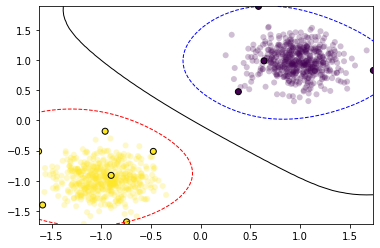

In [5]:
def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""
    
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

def plot_decision_boundary(model, ax, resolution=50, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""
        
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)
        
        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = np.round(model.alphas, decimals=2) != 0.0
        ax.scatter(model.X[mask,0], model.X[mask,1],
                   c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')
        
        return grid, ax
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

# Problem B

In [6]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
sns.set_theme(style='ticks')
iris = datasets.load_iris(as_frame=True)
df = iris.frame


In [7]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


# Part B
## (a) We can clearly see that the sctter matrix (pairplot) determining between class 0 and 1, 2

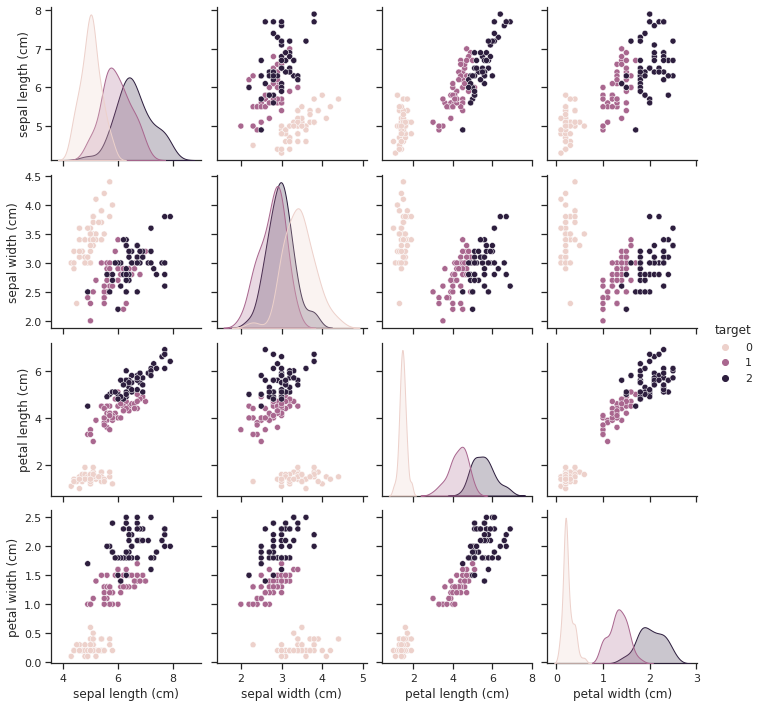

In [8]:
sns.pairplot(df, hue='target')

## (b)

Train test split

In [21]:
from sklearn.model_selection import train_test_split
X = df[iris.feature_names]
y = df.target
y0 = y.replace(1, -1).replace(2, -1).replace(0, 1)
y1 = y.replace(2, -1).replace(0, -1)
y2 = y.replace(1, -1).replace(1, -1).replace(2, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25)

Linear SVM grid search + one_vs_all_classifier

In [82]:
def linear_svm_grid_search(X_train, y_train, X_val, y_val, grid, one, rest):
    best_clf, best_c, best_score = None, 0, 0
    for C in grid['C']:
        svm = SMO(C=C).fit(X_train, y_train)
        score = svm.score(X_val, y_val)
        if score > best_score:
            best_clf, best_c, best_score = svm, C, score
    print(f'Found optimal C={best_c} for set {one} vs {rest}, validation score: {best_score}')
    return best_clf

def create_ova(y_train, y_val, one, rest):
    for v in rest:
        y_train, y_val = y_train.replace(v, -1), y_val.replace(v, -1)
    y_train, y_val = y_train.replace(one, 1), y_val.replace(one, 1)
    return y_train, y_val

def one_vs_all_classifier(X, y, grid):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25)
    all_ys = set(y.values)
    clfs = []
    for one in all_ys:
        rest = all_ys - {one}
        _y_train, _y_val = create_ova(y_train, y_val, one, rest)
        clfs.append(linear_svm_grid_search(X_train, _y_train, X_val, _y_val, grid, one, rest))
    return clfs, X_test, y_test

 "grid-search"

In [83]:
linear_grid_params = {'C': [0.1, 1, 10, 100, 1000, 10000]}
clfs, X_test, y_test = one_vs_all_classifier(X, y, linear_grid_params)

Found optimal C=0.1 for set 0 vs {1, 2}, validation score: 1.0
Found optimal C=1000 for set 1 vs {0, 2}, validation score: 0.6666666666666666
Found optimal C=10 for set 2 vs {0, 1}, validation score: 0.9666666666666667


In [92]:
def ova_score(clfs, X_test, y_test):
    predictions = []
    for x in X_test.to_numpy():
        classifires_and_predictions = [
            (i, clf.decision_function(x))
            for i, clf
            in enumerate(clfs)
        ]
        predictions.append(max(classifires_and_predictions, key=lambda p: p[1])[0])
    predictions = np.array(predictions)
    return sum(y_test[y_test == predictions]) / y_test.shape[0]
ova_score(clfs, X_test, y_test)


0.8666666666666667

### class 0

In [61]:
y_train0, y_val0 = create_ova(y_train, y_val, 0, [1, 2])
best_c0, best_score0 = 0, 0
for C in linear_grid_params['C']:
    svm0 = SMO(C=C).fit(X_train, y_train0)
    score = svm0.score(X_val, y_val0) 
    if score > best_score0:
        best_c0, best_score0 = C, score
best_c0, best_score0

(0.1, 1.0)

### class 1

In [62]:
y_train1, y_val1 = create_ova(y_train, y_val, 1, [0, 2])
best_c1, best_score1 = 0, 0
for C in linear_grid_params['C']:
    svm1 = SMO(C=C).fit(X_train, y_train1)
    score = svm1.score(X_val, y_val1) 
    if score > best_score1:
        best_c1, best_score1 = C, score
best_c1, best_score1

(0.1, 0.7333333333333333)

### class 2

In [63]:
y_train2, y_val2 = create_ova(y_train, y_val, 2, [1, 0])
best_c2, best_score2 = 0, 0
for C in linear_grid_params['C']:
    svm2 = SMO(C=C).fit(X_train, y_train2)
    score = svm2.score(X_val, y_val2) 
    if score > best_score2:
        best_c2, best_score2 = C, score
best_c2, best_score2

(10, 0.9333333333333333)

## (c)

predictions

In [15]:
print(f'Test set predictions: {svm0.predict(X_test0)}')

Test set predictions: [-1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.]


score

In [16]:
print(f'Classifier score on test set: {svm0.score(X_test0, y_test0)}')

Classifier score on test set: 1.0
